# TODO: Title
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [1]:
%%capture
# TODO: Install any packages that you might need
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

In [2]:
# TODO: Import any packages that you might need
import os
import json
import boto3
from tqdm import tqdm
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from sklearn.model_selection import train_test_split

import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [3]:
def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d = json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        train_data, test_data = train_test_split(v, test_size=0.3, random_state=42)
        valid_data, test_data = train_test_split(test_data, test_size=0.33, random_state=42)

        for data, folder in zip([train_data, valid_data, test_data], ['train', 'valid', 'test']):
            directory = os.path.join('data', folder, k)
            if not os.path.exists(directory):
                os.makedirs(directory)
            for file_path in tqdm(data):
                file_name = os.path.basename(file_path).split('.')[0] + '.jpg'
                s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                                        os.path.join(directory, file_name))

In [4]:
%%time
download_and_arrange_data()

100%|██████████| 122/122 [00:11<00:00, 11.03it/s]


100%|██████████| 228/228 [00:19<00:00, 11.50it/s]


100%|██████████| 264/264 [00:24<00:00, 10.73it/s]


100%|██████████| 235/235 [00:21<00:00, 10.92it/s]


100%|██████████| 186/186 [00:15<00:00, 11.67it/s]

CPU times: user 1min 23s, sys: 10.5 s, total: 1min 34s
Wall time: 16min 14s


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [9]:
#TODO: Perform any data cleaning or data preprocessing
def count_data_per_class(directory):
    class_counts = {}
    for root, dirs, files in os.walk(directory):
        for d in dirs:
            class_counts[d] = len(os.listdir(os.path.join(root, d)))
            
    print("Data counts for each class in", directory, "directory:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")
    
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.title('Data Counts per Class in {} Directory'.format(directory))
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    return class_counts

def display_images(directory):
    subdirectories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    print(subdirectories)
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"Images in directory {directory}")

    for i, subdirectory in enumerate(subdirectories):
        print(f"Image in directory {subdirectory}:")
        subdirectory_path = os.path.join(directory, subdirectory)
        image_files = [f for f in os.listdir(subdirectory_path) if f.endswith('.jpg')]
        if image_files:
            image_file = random.choice(image_files)
            image_path = os.path.join(subdirectory_path, image_file)
            img = mpimg.imread(image_path)
            plt.subplot(1,len(subdirectories),i+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Image in directory {subdirectory}")
        else:
            print("No image files found in this directory.")
    plt.tight_layout()


Data counts for each class in ./data/train/ directory:
1: 859
2: 1609
3: 1866
4: 1661
5: 1312
['1', '2', '3', '4', '5']
Image in directory 1:
Image in directory 2:
Image in directory 3:
Image in directory 4:
Image in directory 5:


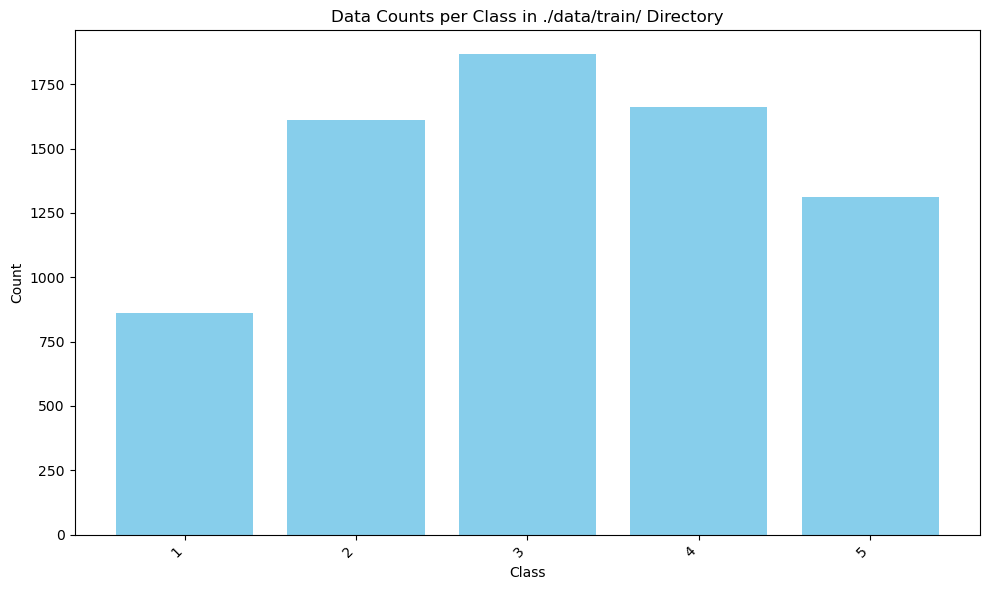

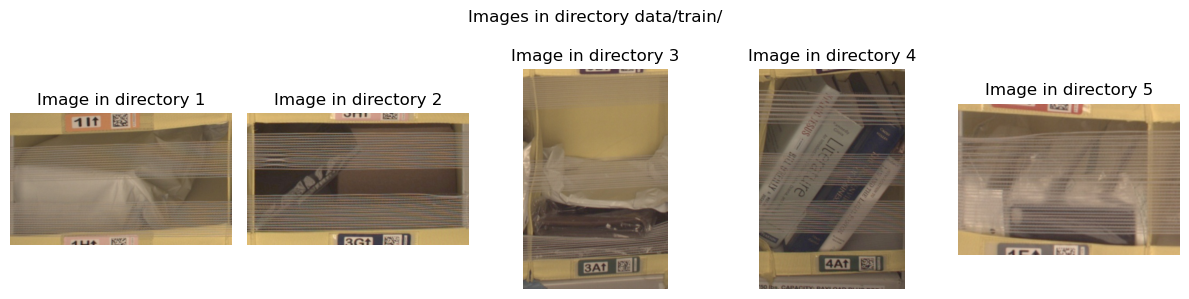

In [10]:
count_data_per_class("./data/train/")
display_images('data/train/')

Data counts for each class in ./data/valid/ directory:
1: 247
2: 462
3: 536
4: 477
5: 377
['1', '2', '3', '4', '5']
Image in directory 1:
Image in directory 2:
Image in directory 3:
Image in directory 4:
Image in directory 5:


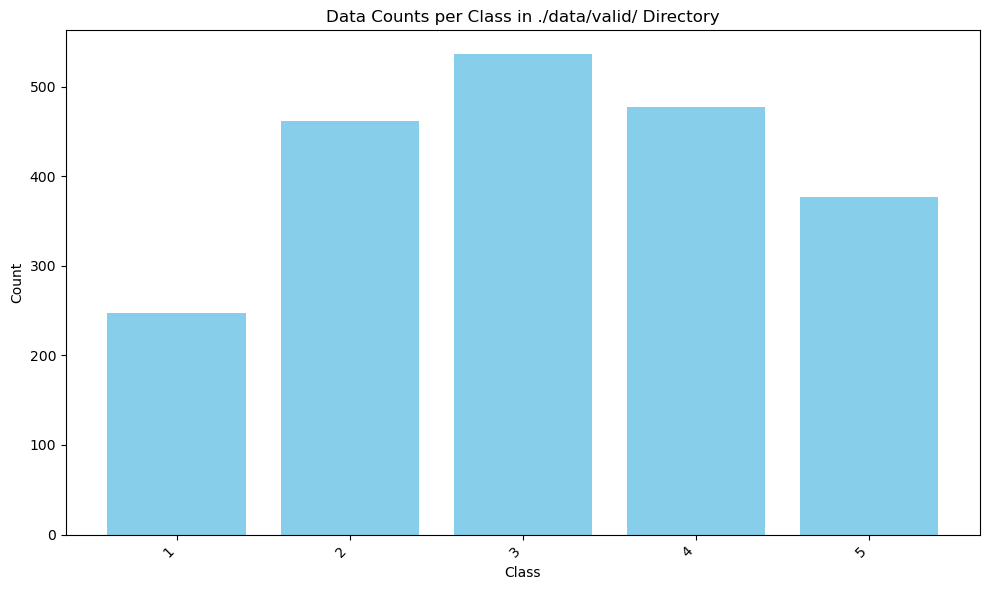

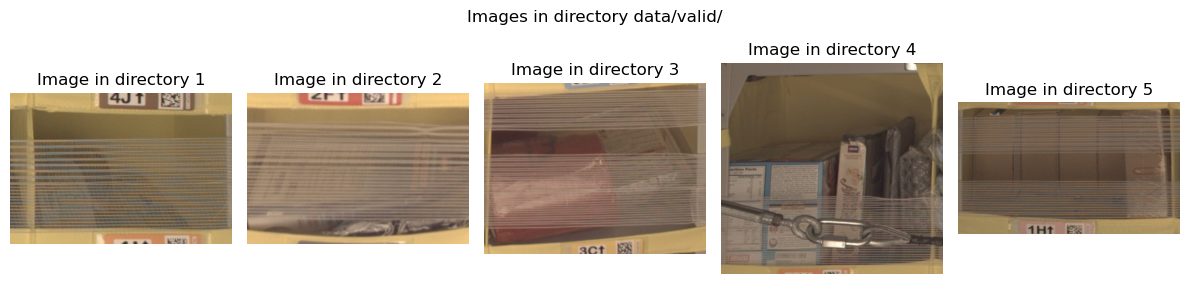

In [11]:
count_data_per_class("./data/valid/")
display_images('data/valid/')

Data counts for each class in ./data/test/ directory:
1: 122
2: 228
3: 264
4: 235
5: 186
['1', '2', '3', '4', '5']
Image in directory 1:
Image in directory 2:
Image in directory 3:
Image in directory 4:
Image in directory 5:


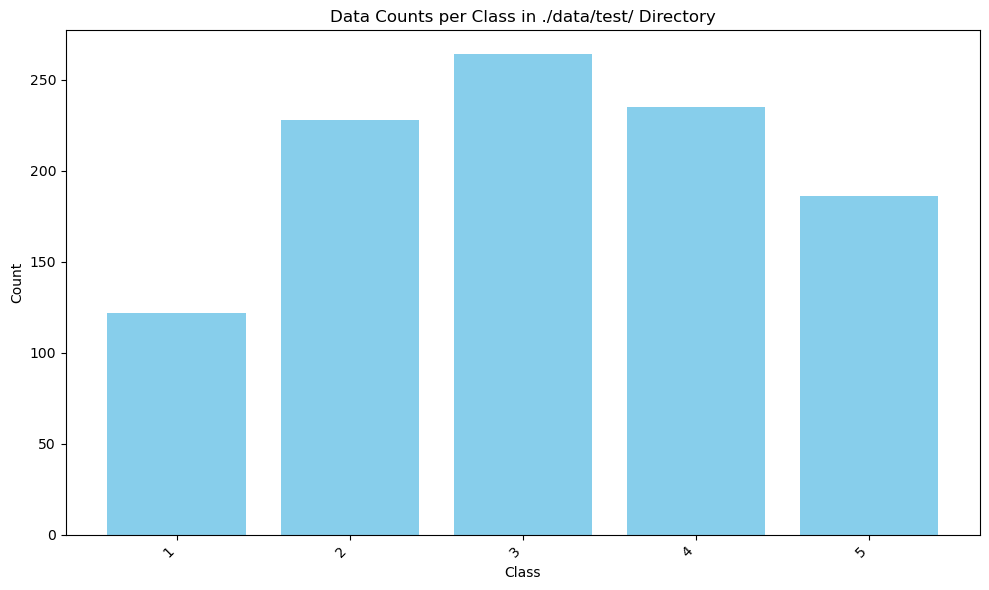

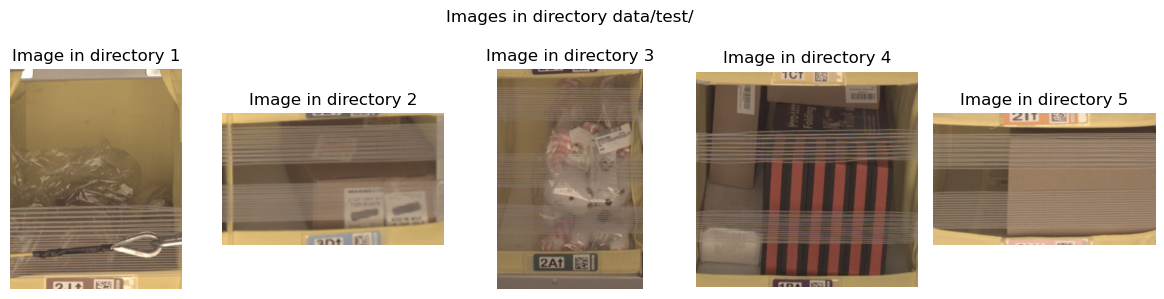

In [12]:
count_data_per_class("./data/test/")
display_images('data/test/')

In [13]:
%%time
#TODO: Upload the data to AWS S3
# !aws s3 cp data s3://capstone/ --recursive

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/capstone/data"
role = sagemaker.get_execution_role()

inputs = sagemaker_session.upload_data(path="./data", bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-051914893063/sagemaker/capstone/data
CPU times: user 1min 2s, sys: 7.31 s, total: 1min 10s
Wall time: 15min 39s


In [14]:
os.environ['SM_CHANNEL_TRAIN'] = "s3://{}/{}/".format(bucket, prefix)
os.environ['SM_MODEL_DIR'] = "s3://{}/{}/{}/".format(bucket, prefix, "output")

print(os.environ['SM_CHANNEL_TRAIN'], os.environ['SM_MODEL_DIR'])

s3://sagemaker-us-east-1-051914893063/sagemaker/capstone/data/ s3://sagemaker-us-east-1-051914893063/sagemaker/capstone/data/output/


## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [15]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values
hyperparameters = {"batch_size": 128,
                   "epochs": 3,
                   "learning_rate": 0.001}
hyperparameters

{'batch_size': 128, 'epochs': 3, 'learning_rate': 0.001}

In [16]:
#TODO: Create your training estimator
# Create and fit an estimator
estimator = PyTorch(
    entry_point="scripts/train.py",
    role=role,
    py_version="py36",
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    hyperparameters=hyperparameters
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [17]:
# TODO: Fit your estimator
estimator.fit({"training": inputs}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker:Creating training-job with name: pytorch-training-2024-02-29-01-13-30-884


2024-02-29 01:13:31 Starting - Starting the training job...
2024-02-29 01:13:43 Pending - Training job waiting for capacity...
2024-02-29 01:14:08 Pending - Preparing the instances for training...
2024-02-29 01:14:47 Downloading - Downloading input data...
2024-02-29 01:15:17 Downloading - Downloading the training image...........................
2024-02-29 01:19:38 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-02-29 01:20:03,324 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-02-29 01:20:03,361 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-02-29 01:20:03,364 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-02-29 01:20:03,683 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [ ]:
#TODO: Create your hyperparameter search space

In [ ]:
#TODO: Create your training estimator

In [ ]:
# TODO: Fit your estimator

In [ ]:
# TODO: Find the best hyperparameters

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [ ]:
# TODO: Deploy your model to an endpoint

In [ ]:
# TODO: Run an prediction on the endpoint

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances